In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import layers, mixed_precision
from keras.datasets import fashion_mnist, imdb, cifar10
from keras.metrics import Precision, Recall, F1Score, AUC
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Dropout, Conv2D, MaxPooling2D, GlobalMaxPool2D, Input, Embedding, SimpleRNN, BatchNormalization
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.constraints import max_norm
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, BackupAndRestore, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from plot_history_lib import plot_history, plot_precision_recall, plot_confusion_matrix, plot_metrics

In [66]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [67]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

In [68]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

size_dataset = X_train.shape[0]
size_test_dataset = X_test.shape[0]
size_vall_dataset = X_valid.shape[0]

batch_size = 128

In [69]:
precision_per_class = [Precision(class_id=i, name=f'precision_class{i}') for i in range(10)]
recall_per_class = [Recall(class_id=i, name=f'recall_class{i}') for i in range(10)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, start_from_epoch=10, verbose=1)
backup = BackupAndRestore(backup_dir="/home/alex/Python_projects/HW_Data_Science/backup", save_freq=5, delete_checkpoint=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.98, patience=25, min_lr=0.00045)

log_dir = "/home/alex/Python_projects/HW_Data_Science/log/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [71]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

class MyFilterModelMP():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.0009),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model

In [72]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=10,
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size)

In [73]:
model_build = MyFilterModelMP()
model = model_build.build()
history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    callbacks=[early_stopping, backup, tensorboard]
)

/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


352/352 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.2866 - loss: 2.0270 - precision_class0: 0.5768 - precision_class1: 0.4638 - precision_class2: 0.4435 - precision_class3: 0.1972 - precision_class4: 0.2808 - precision_class5: 0.6734 - precision_class6: 0.5226 - precision_class7: 0.5532 - precision_class8: 0.7042 - precision_class9: 0.4221 - recall_class0: 0.0256 - recall_class1: 0.0102 - recall_class2: 0.0037 - recall_class3: 5.0262e-04 - recall_class4: 0.0011 - recall_class5: 0.0148 - recall_class6: 0.0051 - recall_class7: 0.0038 - recall_class8: 0.0361 - recall_class9: 7.4195e-04 - val_accuracy: 0.4746 - val_loss: 1.5636 - val_precision_class0: 0.7957 - val_precision_class1: 0.6538 - val_precision_class2: 0.7000 - val_precision_class3: 0.8000 - val_precision_class4: 0.8966 - val_precision_class5: 0.8072 - val_precision_class6: 0.8364 - val_precision_class7: 0.7674 - val_precision_class8: 0.8161 - val_precision_class9: 0.7500 - val_recall_class0: 0.2819 - val_recall_class1: 0.1

In [74]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
path = f"/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16_start_{time}.keras"
model.save(path)

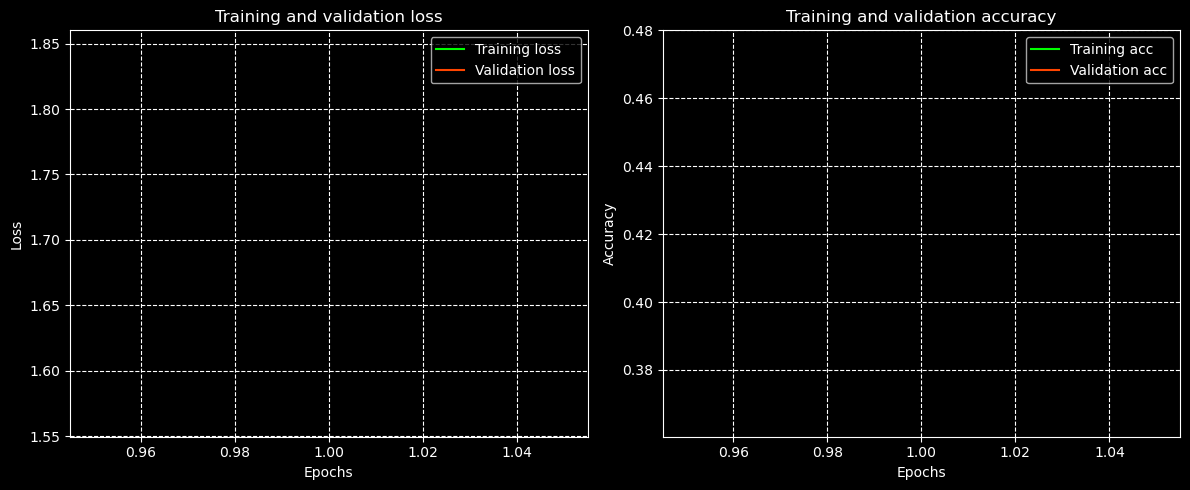

In [75]:
plot_history(history)

In [76]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)         │ 14,714,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_5 (Flatten)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,730,080 (56.19 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 10,262 (40.09 KB)

In [77]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [78]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [79]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.00005),
    metrics=all_metrics
)

In [80]:
history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    callbacks=[early_stopping, backup, tensorboard]
)

352/352 ━━━━━━━━━━━━━━━━━━━━ 69s 170ms/step - accuracy: 0.5327 - loss: 1.3464 - precision_class0: 0.7442 - precision_class1: 0.7276 - precision_class2: 0.6590 - precision_class3: 0.5724 - precision_class4: 0.7090 - precision_class5: 0.6898 - precision_class6: 0.7147 - precision_class7: 0.7365 - precision_class8: 0.7646 - precision_class9: 0.7048 - recall_class0: 0.4020 - recall_class1: 0.3731 - recall_class2: 0.1805 - recall_class3: 0.0922 - recall_class4: 0.2287 - recall_class5: 0.2266 - recall_class6: 0.3510 - recall_class7: 0.3323 - recall_class8: 0.4482 - recall_class9: 0.2804 - val_accuracy: 0.6630 - val_loss: 0.9476 - val_precision_class0: 0.8731 - val_precision_class1: 0.7156 - val_precision_class2: 0.8327 - val_precision_class3: 0.6667 - val_precision_class4: 0.7328 - val_precision_class5: 0.7500 - val_precision_class6: 0.7185 - val_precision_class7: 0.7912 - val_precision_class8: 0.8675 - val_precision_class9: 0.7451 - val_recall_class0: 0.5505 - val_recall_class1: 0.7867 - va

In [81]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
path = f"/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16_finish_{time}.keras"
model.save(path)

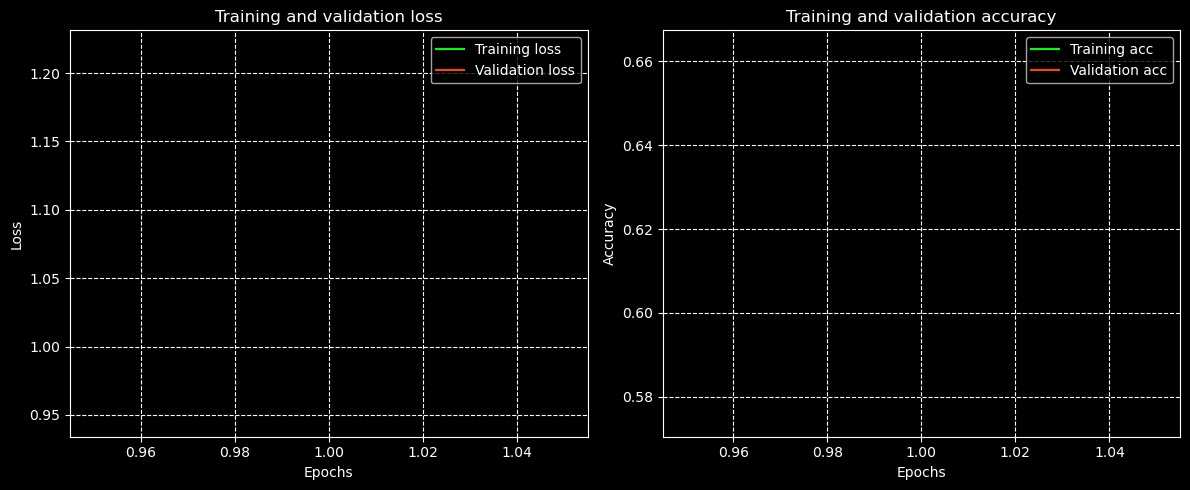

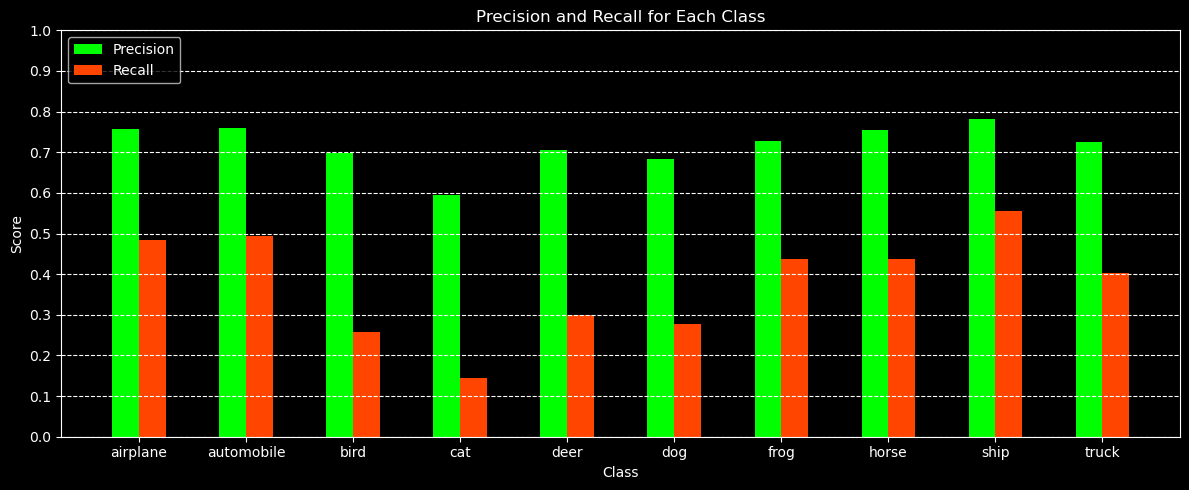

In [82]:
plot_history(history)
plot_precision_recall(history, class_names)